In [1]:
import sys
import pickle
import nltk
from nltk.stem import PorterStemmer
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
sys.path.insert(0, '..')
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
from collections import Counter
import math

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gxb18167\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with open('EEG_Text_Pairs.pkl', 'rb') as file:
    EEG_word_level_embeddings = pickle.load(file)
    train_data = pickle.load(file)

In [3]:
with open('Target_Pred_Strings.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
with open("EEG_Sentences.pkl", 'rb') as f:
    Sentences = pickle.load(f)

In [5]:
target_string_list = data['Target_String']

In [6]:
predicted_string_list = data['Predicted_String']

In [7]:
def get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False):
    Correct_Predictions = {}
    Incorrect_Predictions = {}
    counter_list = []

    train_string = " ".join(train_data)
    train_string_tokenized = word_tokenize(train_string)

    if stemming == True:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(ps.stem(w))
    else:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(w)



    for i in range(len(target_string_list)):
        target_string = target_string_list[i]
        predicted_string = predicted_string_list[i]

        predicted_string = predicted_string[0:len(target_string)]

        target_tokenized = word_tokenize(target_string)

        #print(target_tokenized)
        predicted_tokenized = word_tokenize(predicted_string)

        if stemming == True:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(ps.stem(w))
                counter_list.append(ps.stem(w))
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(ps.stem(w))
        else:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(w)
                counter_list.append(w)
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(w)

        if strict == False:
            for word in target_tokenized_stemmed:
                if word in predicted_tokenized_stemmed:
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1
        else:
            min_length = min(len(predicted_tokenized_stemmed), len(target_tokenized_stemmed))
            for i in range(min_length):
                if target_tokenized_stemmed[i] == predicted_tokenized_stemmed[i]:
                    word = target_tokenized_stemmed[i]
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    word = target_tokenized_stemmed[i]
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1



    target_word_counter = Counter(counter_list)
    print(len(target_word_counter))
    word_frequency = Counter(train_string_tokenized_stemmed)
    print(len(word_frequency))

    common_keys = set(target_word_counter.keys()) & set(word_frequency.keys())
    word_frequency = {k: word_frequency[k] for k in common_keys}



    return Correct_Predictions, Incorrect_Predictions, word_frequency


In [8]:
import re


def calculate_tf(sentences):
    term_frequencies = []

    for sentence in sentences:
        # Preprocess the sentence: convert to lowercase and remove non-alphanumeric characters
        preprocessed_sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower())

        # Tokenize the sentence into words
        words = preprocessed_sentence.split()

        # Calculate term frequency using Counter
        term_frequency = Counter(words)

        # Normalize term frequency by dividing by the total number of terms in the sentence
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}

        term_frequencies.append(normalized_tf)

    return term_frequencies

In [9]:
def calculate_idf(sentences):
    preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
    unique_terms = set([term for words in preprocessed_sentences for term in words])
    doc_frequencies = Counter()
    for term in unique_terms:
        for words in preprocessed_sentences:
            if term in words:
                doc_frequencies[term] += 1
    total_documents = len(sentences)
    idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
    return idf_results

In [249]:
Correct_Predictions, Incorrect_Predictions, word_frequency = get_word_classifcation_count(target_string_list, predicted_string_list, Sentences, stemming=True, strict=False)

873
3978


In [250]:
idf = calculate_idf(Sentences)

In [251]:
def Calc_Correct_Incorrect_Accuracy(Incorrect_Predictions, Correct_Predictions):
    Incorrect_Predictions_Keys = list(Incorrect_Predictions.keys())
    Correct_Predictions_Keys = list(Correct_Predictions.keys())
    # Combine keys into a list
    combined_keys = Incorrect_Predictions_Keys + Correct_Predictions_Keys
    # Remove duplicate keys
    combined_keys = list(set(combined_keys))
    len(combined_keys)

    Accuracy = {}

    for key in combined_keys:
        if key in Incorrect_Predictions and key in Correct_Predictions:
            Accuracy[key] = Correct_Predictions[key]/(Correct_Predictions[key] + Incorrect_Predictions[key])
        elif key in Incorrect_Predictions and key not in Correct_Predictions:
            Accuracy[key] = 0
        elif key in Correct_Predictions and key not in Incorrect_Predictions:
            Accuracy[key] = 1
        else:
            print("Error")

    return Accuracy


In [252]:
Accuracy = Calc_Correct_Incorrect_Accuracy(Incorrect_Predictions, Correct_Predictions)

In [253]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

stop_words_accuracy = {}
stop_word_removal_Accuracy = {}
for key, value in Accuracy.items():
    if key not in sw_nltk:
        stop_word_removal_Accuracy[key] = Accuracy[key]
    else:
        stop_words_accuracy[key] = Accuracy[key]

#Filtering out words that are and are not present in the stop words list
IDF_stop_word_removal_Accuracy = {key: idf[key] for key in stop_word_removal_Accuracy if key in idf}
IDF_stop_words_accuracy = {key: idf[key] for key in stop_words_accuracy if key in idf}

In [254]:
IDF_stop_word_removal_Accuracy_list = list(IDF_stop_word_removal_Accuracy.values())
IDF_stop_words_accuracy_list = list(IDF_stop_words_accuracy.values())

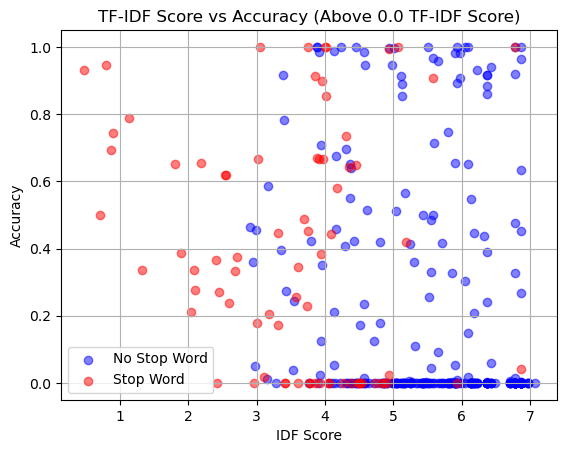

In [255]:
import matplotlib.pyplot as plt
idf_threshold = 0.00  # Adjust as needed

# Filter words based on TF-IDF score threshold
'''
Accuracy_IDF_Filtered = [word for word, Accuracy_IDF in Accuracy_IDF.items() if Accuracy_IDF > idf_threshold]
Accuracy_IDF_Filtered = [Accuracy_IDF[word] for word in Accuracy_IDF_Filtered]
'''
stop_word_removal_Accuracy_filtered = [stop_word_removal_Accuracy[word] for word in IDF_stop_word_removal_Accuracy]

stop_words_accuracy_filtered = [stop_words_accuracy[word] for word in IDF_stop_words_accuracy]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(IDF_stop_word_removal_Accuracy_list, stop_word_removal_Accuracy_filtered, color='blue', alpha=0.5, label='No Stop Word')

# Plot incorrect predictions in red
ax.scatter(IDF_stop_words_accuracy_list, stop_words_accuracy_filtered, color='red', alpha=0.5, label='Stop Word')

# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Accuracy')
plt.title('TF-IDF Score vs Accuracy (Above {} TF-IDF Score)'.format(idf_threshold))

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()

In [256]:
#Looking at best and lowest performing non-stop words
import pandas as pd

common_keys = set(stop_word_removal_Accuracy.keys()) & set(IDF_stop_word_removal_Accuracy.keys())
df = pd.DataFrame({'Word': list(common_keys),
                   'Accuracy': [stop_word_removal_Accuracy[key] for key in common_keys],
                   'IDF': [IDF_stop_word_removal_Accuracy[key] for key in common_keys]})


In [257]:
len(df)

291

In [258]:
# Filter the DataFrame based on accuracy
import plotly.express as px



filtered_df = df[df['Accuracy'] > 0.8]

# Sort the DataFrame based on IDF values
filtered_df = filtered_df.sort_values(by='IDF')

# Scatter plot
fig = px.scatter(filtered_df, x='Word', y='Accuracy', size='IDF',
                 labels={'Accuracy': 'Word Accuracy', 'IDF': 'IDF Value'},
                 title='Words with Accuracy Sorted by IDF Values')

# You can customize the layout further if needed
fig.update_layout(xaxis_title='Unique Words (Sorted by IDF)', yaxis_title='Accuracy', showlegend=True)

# Add annotation at the top of the figure
fig.add_annotation(
    x=0.5,
    y=1.1,
    xref='paper',
    yref='paper',
    text='IDF Scores: Low to High',
    showarrow=False,
    font=dict(size=14)
)

# Show the plot
fig.show()

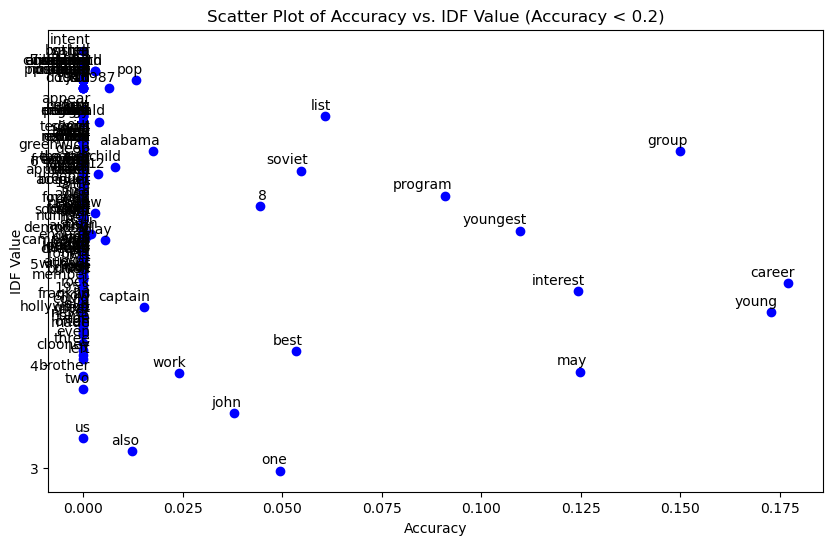

In [259]:
# Scatter plot

# Set the accuracy threshold
accuracy_threshold = 0.2

# Filter the DataFrame based on the accuracy threshold
filtered_df = df[df['Accuracy'] < accuracy_threshold]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['Accuracy'], filtered_df['IDF'], marker='o', color='blue')

# Label each point with the corresponding word
for i, word in enumerate(filtered_df['Word']):
    plt.annotate(word, (filtered_df['Accuracy'].iloc[i], filtered_df['IDF'].iloc[i]), textcoords="offset points", xytext=(5,5), ha='right')

# Set plot labels and title
plt.xlabel('Accuracy')
plt.ylabel('IDF Value')
plt.title(f'Scatter Plot of Accuracy vs. IDF Value (Accuracy < {accuracy_threshold})')

# Show the plot
plt.show()

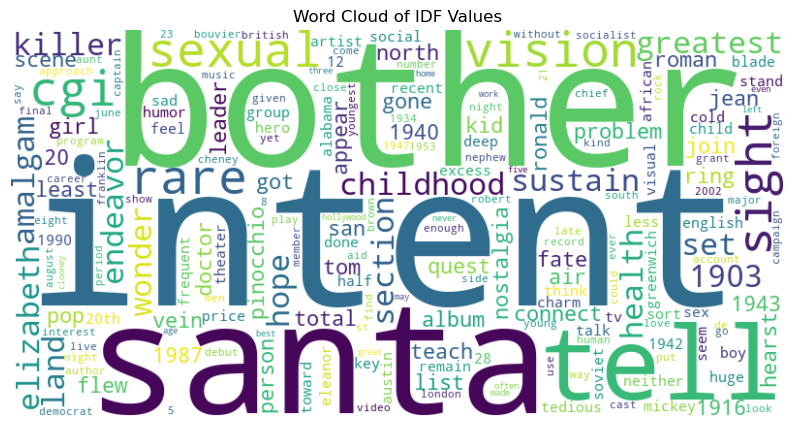

In [260]:
from wordcloud import WordCloud

filtered_df = df[df['Accuracy'] < 0.2]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(filtered_df['Word'], filtered_df['IDF'])))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of IDF Values')
plt.show()